<a href="https://colab.research.google.com/github/americanthinker/rag-applications/blob/main/notebooks/4-Reranking_Week2.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 4

# Overview

Welcome to Week 2 of the course!  We covered a lot of content last week in order to get to the point where we can search over our data.  In this notebook, you'll have the chance to improve your baseline retrieval scores by combining the strengths of keyword and vector search using Weaviate's `hybrid_search` method.  We'll also incorporate the use of a CrossEncoder reranker to pack the final punch in our retrieved hits, before we pass those results to the LLM for answer synthesis.  Here's a reminder of where we've been and where we're going:

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* ~Part 2~:
  * ~Index data on Weaviate database~
  * ~Search over data~
* ~Part 2.5~:
  * ~Benchmark retrieval results~

#### Week Two
* **Part 4 (THIS NOTEBOOK)**:
  * **Add Hybrid Search and ReRanker to the mix (new benchmark)**
* Part 5:
  * LLM Integration

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch diagram]( 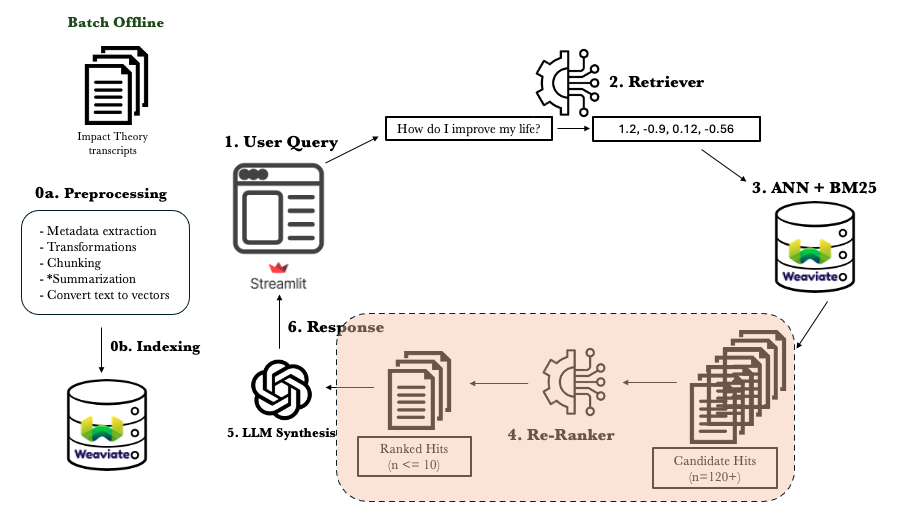)

## If running in Colab, uncomment cells below!

In [1]:
!pip install tqdm --quiet
!pip install rich --quiet
!pip install python-dotenv --quiet
!pip install loguru --quiet
!pip install tiktoken --quiet
!pip install litellm --quiet
!pip install instructor --quiet
!pip install weaviate-client --quiet

In [2]:
!mkdir src
!mkdir src/preprocessor
!mkdir src/database
!mkdir src/evaluation
!mkdir src/llm
!mkdir data
!mkdir data/golden_datasets

mkdir: cannot create directory ‘src’: File exists
mkdir: cannot create directory ‘src/preprocessor’: File exists
mkdir: cannot create directory ‘src/database’: File exists
mkdir: cannot create directory ‘src/evaluation’: File exists
mkdir: cannot create directory ‘src/llm’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/golden_datasets’: File exists


In [3]:
!curl -o src/preprocessor/preprocessing.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/preprocessor/preprocessing.py
!curl -o src/database/weaviate_interface_v4.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/database/weaviate_interface_v4.py
!curl -o src/reranker.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/reranker.py
!curl -o src/evaluation/eval_prompt_templates.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/evaluation/eval_prompt_templates.py
!curl -o src/llm/llm_utils.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/llm_utils.py
!curl -o src/llm/llm_interface.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/llm_interface.py
!curl -o src/llm/prompt_templates.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/prompt_templates.py
!curl -o src/evaluation/retrieval_evaluation.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/evaluation/retrieval_evaluation.py
!curl -o src/data_models.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/data_models.py
!curl -o data/golden_datasets/golden_256.json https://raw.githubusercontent.com/americanthinker/rag-applications/main/data/golden_datasets/golden_256.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5501  100  5501    0     0  35657      0 --:--:-- --:--:-- --:--:-- 35720
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21404  100 21404    0     0   193k      0 --:--:-- --:--:-- --:--:--  193k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3700  100  3700    0     0  39879      0 --:--:-- --:--:-- --:--:-- 40217
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9465  100  9465    0     0  84536      0 --:--:-- --:--:-- --:--:-- 85270
  % Total    % Received % Xferd  Average Speed   Tim

In [6]:
import sys
sys.path.append('../')

# Google colab
from google.colab import userdata

#load from local .env file
from dotenv import load_dotenv, find_dotenv
env = load_dotenv(find_dotenv(), override=True)

#standard python
import os

# external libraries
from tqdm import tqdm
from rich import print  # nice library that provides improved printing output (overrides default print function)

# external files
from src.reranker import ReRanker
from src.database.weaviate_interface_v4 import WeaviateWCS

## Setup
***

### Instaniate Weaviate Client

In [16]:
#read env vars from local .env file

api_key = os.environ.get("WEAVIATE_API_KEY", None) or userdata.get('WEAVIATE_API_KEY')
url = os.environ.get("WEAVIATE_ENDPOINT", None) or userdata.get('WEAVIATE_ENDPOINT')

#instantiate client
client = WeaviateWCS(url, api_key)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
#display available collection names on cluster
client.show_all_collections()

['Huberman_minilm_12_512', 'Huberman_minilm_12_128', 'Huberman_minilm_12_256']

### Set Collection name

In [18]:
#set collection name to run queries on
collection_name = "Huberman_minilm_12_128"

## Discussion  

Hybrid search does just what it sounds like: it combines a keyword search with a vector search, which has the effect of combining the strengths of each method for improved retrieval.  If you'll recall, the initial vector retrieval results we saw with our out-of-the-box `miniLM` model were about 10 percentage points lower compared to the keyword results. My initial results with the `chunk_size` 256 dataset were:

```
{'n': 5,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'chunk_size': 256,
 'query_props': ['content'],
 'kw_hit_rate': 0.78,
 'kw_mrr': 0.64,
 'vector_hit_rate': 0.68,
 'vector_mrr': 0.56,
 'total_misses': 16,
 'total_questions': 100
}
```
You may also have noticed that the `total_misses` score was `16`, meaning that neither search method picked up the golden `doc_id` in the "n" retrieved results, a total of 16 times.  From another perspective, it means that between keyword and vector search, they found 84 out of 100 of the golden `doc_ids`.  So if 84 docs were found then how come we don't see a hit rate score of 84 in one of the two methods....?

If you compare the total misses with the keyword hit rate (the highest scoring method), you'll see that keyword picked up 78 of the correct docs, but that 84 docs were found between the two methods.  We can interpret this to mean that the vector search method accounts for the difference of 6 hits between the keyword hit rate and the total of 84 correct documents found.  Combining these two search methods through hybrid search allows us to close this gap.

# Hybrid Search - `RelativeRankFusion`  
If you recall from the [Course Notes](https://weaviate.io/blog/hybrid-search-fusion-algorithms), Weaviate's Hybrid search method uses the `RelativeRankFusion` algorithm under the hood. Combining keyword and vector search scores is an area of active research, so the algorithm used by Weaviate is "a" way to perform hybrid search, not "the" way.  

**Let's walk through the steps at a high level and then break it down in code:**
1. Execute a keyword and a vector search and get the raw scores and doc_ids of each.
2. Normalize scores between 0 and 1 relative to each method.
3. Multiply the normalized scores by a weighted value: `alpha`.
4. Add scores together that both have the same `doc_id`.
5. Combine search results together in ranked order according to score values.

### Get responses to query

In [19]:
query = 'Why is sleep so important to maximizing healthspan'

In [20]:
kw_response = client.keyword_search(query, collection_name, limit=10)
vector_response = client.vector_search(query, collection_name, limit=10)

### Extract scores and doc_ids

In [22]:
from collections import OrderedDict, defaultdict

def get_scores_ids(response: list[dict], include_cross_score: bool=False, limit: int=10):
    '''
    Extracts scores and ids from response object.
    If keyword, extracts from "score" field.
    If vector, extracts from "distance" field and
    subtracts from 1 in keeping with the concept that
    higher scores are better.
    '''
    def round_(score: str, place: int=3):
        return round(float(score),place)

    score_dict = OrderedDict()
    if response[0].get('score'):
        if include_cross_score:
            return {d['doc_id'] : f'Score: {round_(d["score"])}   :   Cross-Score: {round_(d["cross_score"])}' for d in response[:limit]}
        return {d['doc_id'] : round_(d['score'], 3) for d in response[:limit]}
    return {d['doc_id'] : round_(1 - d['distance'],3) for d in response[:limit]}

### Raw scores
Using the above function we're going to pull out the `doc_ids` and the raw (unnormalized) scores from each search method. Note the difference in score magnitude between BM25 ranking and the Cosine score.

In [23]:
raw_kw_scores = get_scores_ids(kw_response)
raw_vec_scores = get_scores_ids(vector_response)
raw_kw_scores, raw_vec_scores

({'ufsIA5NARIo_2': 8.662,
  'ufsIA5NARIo_18': 6.276,
  'q1Ss8sTbFBY_0': 5.765,
  'oNkDA2F7CjM_109': 5.708,
  'q37ARYnRDGc_280': 5.349,
  'oUu3f0ETMJQ_135': 5.117,
  'ufsIA5NARIo_375': 4.93,
  'nDLb8_wgX50_157': 4.853,
  'VQLU7gpk_X8_205': 4.831,
  'oNkDA2F7CjM_144': 4.815},
 {'poOf8b2WE2g_17': 0.438,
  'ncSoor2Iw8k_31': 0.424,
  'qJXKhu5UZwk_97': 0.418,
  'dzOvi0Aa2EA_191': 0.416,
  'gXvuJu1kt48_296': 0.412,
  'h2aWYjSA1Jc_3': 0.407,
  'BMTt8gSl13s_4': 0.406,
  'HYVeP4F0GNU_151': 0.404,
  '-wIt_WsJGfw_13': 0.402,
  'gbQFSMayJxk_150': 0.401})

### Normalize scores relative to each method
Normalize all scores so that the values are between 0 and 1 relative to one other **within** each method.  In other words we are normalizing scores for each method, not normalizing across all scores, because this will not work in practice given that a BM25 score has no meaning relative to a Cosine Similarity score.  

In [24]:
#using sklearn to normalize scores
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray

scaler = MinMaxScaler()
kw_normal = scaler.fit_transform([[score] for score in raw_kw_scores.values()])
vec_normal = scaler.fit_transform([[score] for score in raw_vec_scores.values()])
kw_normal, vec_normal

(array([[1.        ],
        [0.37977645],
        [0.24694567],
        [0.23212893],
        [0.13880946],
        [0.07850273],
        [0.02989342],
        [0.00987783],
        [0.00415909],
        [0.        ]]),
 array([[1.        ],
        [0.62162162],
        [0.45945946],
        [0.40540541],
        [0.2972973 ],
        [0.16216216],
        [0.13513514],
        [0.08108108],
        [0.02702703],
        [0.        ]]))

### Multiply by weighted alpha value

Weight the values by multiplying by the `alpha` parameter. `alpha` is an indication of how strong we want to weight the scores toward vector search.  Setting `alpha` to 0 results in a pure keyword search (vector scores will be multiplied by 0, meaning they won't be considered as part of the search results) and setting `alpha` to 1 results in a pure vector-based search. For this example we'll set `alpha` to `0.45` meaning we'll multiply the vector scores by `0.45` (thus diminishing their importance to the returned results) and multiply the keyword scores by `0.55` (boosting their importance to the returned results).  

In [25]:
alpha = 0.45
kw_weighted = kw_normal * (1 - alpha)
vec_weighted = vec_normal * alpha
kw_weighted, vec_weighted

(array([[0.55      ],
        [0.20887705],
        [0.13582012],
        [0.12767091],
        [0.0763452 ],
        [0.0431765 ],
        [0.01644138],
        [0.0054328 ],
        [0.0022875 ],
        [0.        ]]),
 array([[0.45      ],
        [0.27972973],
        [0.20675676],
        [0.18243243],
        [0.13378378],
        [0.07297297],
        [0.06081081],
        [0.03648649],
        [0.01216216],
        [0.        ]]))

### Update final scores

After intra-method normalization and score weighting, we can now update our docs with their new scores.  One more step to complete is to add together any scores coming from the same document in both results.  This should make intuitive sense, we want to boost the scores of documents that **both** methods picked up.  

In [26]:
def update_scores(weighted_kw_scores: ndarray,
                  weighted_vec_scores: ndarray
                 ) -> None:
    updated_kw_scores = {}
    updated_vec_scores = {}
    for i, k in enumerate(raw_kw_scores):
        updated_kw_scores[k] = weighted_kw_scores[i][0]
    for i, k in enumerate(raw_vec_scores):
        updated_vec_scores[k] = weighted_vec_scores[i][0]
    return updated_kw_scores, updated_vec_scores

In [27]:
updated_kw_scores, updated_vec_scores = update_scores(kw_weighted, vec_weighted)

#the updated scores should look very different from their original raw scores
print(updated_kw_scores, updated_vec_scores)

{
    'ufsIA5NARIo_2': 0.55,
    'ufsIA5NARIo_18': 0.20887704704964896,
    'q1Ss8sTbFBY_0': 0.1358201195736937,
    'oNkDA2F7CjM_109': 0.12767091239927209,
    'q37ARYnRDGc_280': 0.07634520405510788,
    'oUu3f0ETMJQ_135': 0.04317650116974258,
    'ufsIA5NARIo_375': 0.016441382895762847,
    'nDLb8_wgX50_157': 0.00543280478294762,
    'VQLU7gpk_X8_205': 0.0022874967507148904,
    'oNkDA2F7CjM_144': 0.0
}
{
    'poOf8b2WE2g_17': 0.45,
    'ncSoor2Iw8k_31': 0.2797297297297295,
    'qJXKhu5UZwk_97': 0.20675675675675684,
    'dzOvi0Aa2EA_191': 0.18243243243243237,
    'gXvuJu1kt48_296': 0.13378378378378342,
    'h2aWYjSA1Jc_3': 0.07297297297297263,
    'BMTt8gSl13s_4': 0.06081081081081159,
    'HYVeP4F0GNU_151': 0.03648648648648711,
    '-wIt_WsJGfw_13': 0.012162162162162638,
    'gbQFSMayJxk_150': 0.0
}

### Review top hits from each method  
Pause at this point to look at the top couple of hits of each search method to gain a better understanding of how these hits are being ranked by each search method.  You'll note here, assuming you executed this query `Why is sleep so important to maximizing healthspan` that the top hits for each method are not only different, they are also unique across the top 10 results for each. This point is important because it indicates that while the general meaning between the two search results may be simliar, the actual content can be very different, hence the need for a hybrid method that combines the best of both worlds.

In [28]:
def review_top_n_hits(updated_kw_scores: dict, updated_vec_scores: dict, top_n: int=2, return_hits: bool=False):
    """Filters and prints top-n hits from search results"""
    kw_top_scores = sorted(updated_kw_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    vec_top_scores = sorted(updated_vec_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    kw_hits = [hit[0] for hit in kw_top_scores]
    vec_hits = [hit[0] for hit in vec_top_scores]
    for i, hit in enumerate(kw_hits, 1):
        content = [response['content'] for response in kw_response if response['doc_id'] == hit][0]
        print(f'KEYWORD RESPONSE: {i}\n{content}')
    for i, hit in enumerate(vec_hits, 1):
        content = [response['content'] for response in vector_response if response['doc_id'] == hit][0]
        print(f'VECTOR RESPONSE: {i}\n{content}')
    if return_hits:
        return kw_hits, vec_hits

In [29]:
review_top_n_hits(updated_kw_scores, updated_vec_scores)

KEYWORD RESPONSE: 1
What follows is an incredibly informative and actionable set of tools for anyone, male, female, young, or old. He 
explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can 
use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all 
pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is 
something that not a lot of people think about when they think about healthspan and longevity, but as Dr.

KEYWORD RESPONSE: 2
Even in laboratory experiments with mice, that's sort of one of the metrics that's discussed is what's maximal 
lifespan of the animals. But there's an equally, if not slightly, I think potentially more important part of 
longevity, which is healthspan. And healthspan is squishier and I think it requires some definition. Now the 
medical definition of healthspan is the period of time by which you are free from disability and disease. I find 
that to be a not particularly helpful definition because by that definition you and I have the same health span 
today that we did 30 years ago.

VECTOR RESPONSE: 1
And there is now a sort of generic form of that answer that deserves our respect, but is not going to be the topic 
of conversation today. I just want to tip my hat to it, however, and list off a few of the things that we know set 
us up to be healthier than we would be if we didn't do these things. So the first of course is the foundation of 
all mental and physical health, which is to get adequate sleep, meaning enough sleep, whatever it is for you that 
you require to get deep sleep.

VECTOR RESPONSE: 2
When you're a member of a family or even a very close friend, trying to achieve optimal health together is very 
important. It's the same thing with nicotine cessation, it's the same thing with hormone optimization. If you do it
as a household unit, it's far more helpful. So after stress, you have sleep optimization. Sleep is extremely 
important, especially for mitochondrial health as well. And then you have sunlight, which encompasses anything 
that's outdoors. So you move more, you have cold exposure, you have heat exposure, that's sunlight. And then last 
one is spirit.

### Add together any documents with the same doc_id and then sort final results

In [30]:
def add_doc_scores(updated_kw_scores: dict[str, float],
                   updated_vec_scores: dict[str, float],
                   top_k: int=5
                  ) -> list[tuple[str, float]]:
    '''
    Combined keyword and vector scores by adding values
    for any duplicate docs and then sorts resulting
    dictionary of results.  Returns top_k values.
    '''
    hybrid_results = updated_kw_scores
    for k,value in updated_vec_scores.items():
        if k in updated_kw_scores:
            hybrid_results[k] += value
        else:
            hybrid_results[k] = value
    return sorted(hybrid_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [31]:
# #compare these final ranked value with the original keyword and vector queries
ranked_results = add_doc_scores(updated_kw_scores, updated_vec_scores, top_k=5)
ranked_results

[('ufsIA5NARIo_2', 0.55),
 ('poOf8b2WE2g_17', 0.45),
 ('ncSoor2Iw8k_31', 0.2797297297297295),
 ('ufsIA5NARIo_18', 0.20887704704964896),
 ('qJXKhu5UZwk_97', 0.20675675675675684)]

### Compare manually generated scores with Weaviate hybrid method

In [32]:
#scores and ranking are slightly off due to the way that keyword results are processed

hyb_response = client.hybrid_search(query, collection_name, alpha=alpha, limit=5)
get_scores_ids(hyb_response), ranked_results

({'ufsIA5NARIo_2': 0.55,
  'poOf8b2WE2g_17': 0.45,
  'ncSoor2Iw8k_31': 0.379,
  'qJXKhu5UZwk_97': 0.354,
  'dzOvi0Aa2EA_191': 0.344},
 [('ufsIA5NARIo_2', 0.55),
  ('poOf8b2WE2g_17', 0.45),
  ('ncSoor2Iw8k_31', 0.2797297297297295),
  ('ufsIA5NARIo_18', 0.20887704704964896),
  ('qJXKhu5UZwk_97', 0.20675675675675684)])

# Assignment 2.1 - Compare Search Methods
***
**Submit queries using the various search methods and observe how the results, and their ordering, changes.**

#### Instructions:
- Run the print statements and observe how the results change (or don't) based on the search method.
- Play around with the `alpha_value` parameter and notice how the hybrid search results match the other search methods depending on how close to zero or one the value is.
- Once you have a comfortable understanding of how hybrid search compares to the other methods, move on to Reranking.

In [33]:
def print_results_by_key(results: list[dict], return_props: list[str]) -> None:
    '''
    Pretty-prints nested search results
    '''
    from rich.pretty import pprint
    keys = return_props + ['score', 'distance']
    for r in results:
        for key in r:
            if key in keys:
                pprint(f'{key.upper()}: {r[key]}')
        print('\n\n')
    print('-'*100)

In [34]:
def print_results(client: WeaviateWCS,
                  collection_name: str,
                  queries: list[str],
                  return_props: list[str],
                  alpha_value: float
                  ) -> None:
    '''
    Prints search results grouped by search method
    '''
    for q in queries:
        kw_result = client.keyword_search(q, collection_name, return_properties=return_props, limit=3)
        vector_result = client.vector_search(q, collection_name, return_properties=return_props, limit=3)
        hybrid_result = client.hybrid_search(q, collection_name, return_properties=return_props, alpha=alpha_value, limit=3)
        print('*'*100)
        print(f'QUERY: {q}')
        print(f'KEYWORD RESULTS:')
        print_results_by_key(kw_result, return_props)
        print(f'VECTOR RESULTS:')
        print_results_by_key(vector_result, return_props)
        print(f'HYBRID RESULTS:')
        print_results_by_key(hybrid_result, return_props)

In [35]:
queries = ['How to fight age-related muscle loss', 'Ways to increase dopamin naturally', 'What is the role of the mid-singulate cortex in the human brain']
return_props = ['title', 'content', 'doc_id']
alpha_value = 0.4

print_results(client, collection_name, queries, return_props, alpha_value)

****************************************************************************************************

QUERY: How to fight age-related muscle loss

KEYWORD RESULTS:

"CONTENT: I also would like to make one brief correction to something that I said incorrectly in the previous episode. At the end of the episode, I talked about lutein and how lutein may help offset some moderate to severe age-related macular degeneration. As well, I talked about how some people are supplementing with lutein even though they don't have age-related macular degeneration with the idea in mind that it might help offset some vision loss as they get older."

'TITLE: How Smell, Taste & Pheromone-Like Chemicals Control You'

'DOC_ID: Mwz8JprPeMc_23'

'SCORE: 8.115200996398926'

"CONTENT: Then the next two major causes of currently largely irreversible vision loss are age-related macular degeneration and then diabetic retinopathy. Now, age-related macular degeneration is just like it sounds. Major risk factor is age. It's very common. And actually, in the developed world, you know, countries that are more developed, also countries that have a larger Caucasian white population, it's more common in certain populations than in others. It actually is, you know, definitely a leading cause of vision loss in the elderly population, for example, in the United States."

'TITLE: Dr. Jeffrey Goldberg: How to Improve Your Eye Health & Offset Vision Loss | Huberman Lab Podcast'

'DOC_ID: _ltcLEM-5HU_240'

'SCORE: 7.934934616088867'

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true."

'DOC_ID: CyDLbrZK75U_9'

'SCORE: 7.6944756507873535'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: Again, even something like creatine is going to be a very small effect compared to like proper nutrition, recovery, and hard training. You know, one of the things I was talking with Ben Bruno the other day, and I said, you know, like some people will ask me like, how does this person make progress? Because, you know, their programming is, you know, it's not evidence-based or, or this guy, how's he like, he's, his exercises are dumb. And I'll say, yeah, but they train really hard for 20 years."

'TITLE: Dr Layne Norton: The Science of Eating for Health, Fat Loss & Lean Muscle | Huberman Lab Podcast #97'

'DOC_ID: K4Ze-Sp6aUE_415'

'DISTANCE: 0.5975774526596069'

"CONTENT: And I'd like to point that out because a lot of folks would be like, oh my gosh, they said I have to do it when I'm 20 or 25 or I'll be sort of screwed. And that's not the case at all. There's really no age limit on this. In fact, there's actually interesting data that just came out showing this reduction in muscle strength and hypertrophy that I sort of talked about is basically ameliorated with a preservation of activity. In other words, you don't lose these functionalities because of aging. You lose these because of a loss of training."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_16'

'DISTANCE: 0.5994007587432861'

'CONTENT: And so to just give you one categorically, the way that you want to think about this is resistance exercise and strength training is the number one tool to combat neuromuscular aging. You cannot get that through any other form of exercise besides heavy overload strength training. And we can walk through in detail what that is, but that is reason number one. In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract.'

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_8'

'DISTANCE: 0.6064227819442749'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_9'

'SCORE: 0.8069508075714111'

"CONTENT: I also would like to make one brief correction to something that I said incorrectly in the previous episode. At the end of the episode, I talked about lutein and how lutein may help offset some moderate to severe age-related macular degeneration. As well, I talked about how some people are supplementing with lutein even though they don't have age-related macular degeneration with the idea in mind that it might help offset some vision loss as they get older."

'TITLE: How Smell, Taste & Pheromone-Like Chemicals Control You'

'DOC_ID: Mwz8JprPeMc_23'

'SCORE: 0.6000000238418579'

"CONTENT: But I think the research shows now that everyone of pretty much every age should be doing some sort of resistance exercise, even if that's body weight exercises in order to offset this age-related decline in muscle contractile ability, muscle strength, et cetera, improve bone density. There's nothing good about getting frail and weak over time. And people who invest the effort into doing resistance exercise of some kind, whether or not it's with bands or with weights or with body weight, really benefit tremendously at a whole body level, at a systemic level, as well as in terms of muscle strength."

'TITLE: Science of Muscle Growth, Increasing Strength & Muscular Recovery'

'DOC_ID: XLr2RKoD-oY_86'

'SCORE: 0.5937731862068176'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: Ways to increase dopamin naturally

KEYWORD RESULTS:

"CONTENT: But regardless of when you wake up in the morning, one of the first things that happens is that your body temperature is increasing, and that's just going to happen naturally. Some of it is going to be the consequence of your moving around a bit, but really the increase in body temperature is one of the main triggers for why you woke up in the first place. That increase in body temperature in turn causes an increase in the release of a hormone called cortisol. Cortisol is often discussed as a stress hormone, but it's not just associated with stress."

'TITLE: Sleep Toolkit: Tools for Optimizing Sleep & Sleep-Wake Timing | Huberman Lab Podcast #84'

'DOC_ID: h2aWYjSA1Jc_33'

'SCORE: 4.648410797119141'

"CONTENT: There's a lot of information about this online. For most people, eating foods like Parmesan cheese, eating foods like certain meats and certain vegetables also can increase tyrosine levels, which will increase dopamine synthesis. So these are ways of modulating more or less the baseline of dopamine that you are able to produce and the ways that dopamine can have its action by way of binding to receptors more potently. Now, there are other ways to increase dopamine in a more acute or directed way, ways to spike your dopamine to enhance your state of motivation, mood, focus, and so on."

'TITLE: Optimize & Control Your Brain Chemistry to Improve Health & Performance | Huberman Lab Podcast #80'

'DOC_ID: T65RDBiB5Hs_141'

'SCORE: 4.615876197814941'

'TITLE: Dr. Matthew Walker: The Biology of Sleep & Your Unique Sleep Needs | Huberman Lab Guest Series'

"CONTENT: But coming back to your question, cortisol will drop naturally throughout the night, but then it starts to rise back up and will start to produce its fantastic sort of peak climbing rate right at the moment when you would naturally again want to wake up. So what we're mapping here is this wonderful tapestry, this kaleidoscope of coordinated biology that your adenosine levels are finally coming to their lowest point. Your circadian rhythm is starting to rise. Your cortisol levels are starting to rise. Your core body temperature is starting to increase because it's dropped throughout the night."

'DOC_ID: -OBCwiPPfEU_319'

'SCORE: 4.470930576324463'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: That is not a good approach, especially with something like Fidogeo Agrestis, which can at high dosages be toxic. But it's also important to perhaps consider taking a lower dosage and seeing how that affects your hormones. That approach requires a bit more patience. I know most people are thinking, I want the effect and I want it now, but I think it's very important when thinking about exercise or nutrition or supplementation to really play the long game, to think about what's going to work for you in the immediate end in the longterm and to ease into any kind of supplement regimen."

'TITLE: Developing a Rational Approach to Supplementation for Health & Performance | Huberman Lab Podcast'

'DOC_ID: tLS6t3FVOTI_158'

'DISTANCE: 0.6294684410095215'

"CONTENT: And that seems to be very beneficial, maybe even accelerates neuroplasticity in learning, and indeed there's evidence for that, and there's evidence that yoga nidra, from a laboratory out of Scandinavia, not my laboratory, showing that it can increase dopamine levels in the striatum, basal ganglia, by up to 60% using human positron emission tomography imaging. So we're talking about how to increase dopamine through non-pharmacologic means. This is something about body still, brain active, very, very powerful way to do that."

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

'DOC_ID: ttNxNbqNQK4_62'

'DISTANCE: 0.6353548765182495'

'TITLE: Optimize & Control Your Brain Chemistry to Improve Health & Performance | Huberman Lab Podcast #80'

"CONTENT: In fact, it's the kind of thing that if you want to increase dopamine for sake of motivation, it might be your first go-to, provided you're also doing the things to maintain dopamine baseline, like sunlight exposure in particular, making sure you're getting sufficient amounts of tyrosine containing foods and so on. And now just very briefly, I want to point to a few quick tools that good peer-reviewed data tell us can be leveraged in order to make sure that you have sufficient dopamine when you want it, or that it's available for it to be released by any number of the tools I've provided thus far."

'DOC_ID: T65RDBiB5Hs_162'

'DISTANCE: 0.6399092674255371'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: There's a lot of information about this online. For most people, eating foods like Parmesan cheese, eating foods like certain meats and certain vegetables also can increase tyrosine levels, which will increase dopamine synthesis. So these are ways of modulating more or less the baseline of dopamine that you are able to produce and the ways that dopamine can have its action by way of binding to receptors more potently. Now, there are other ways to increase dopamine in a more acute or directed way, ways to spike your dopamine to enhance your state of motivation, mood, focus, and so on."

'TITLE: Optimize & Control Your Brain Chemistry to Improve Health & Performance | Huberman Lab Podcast #80'

'DOC_ID: T65RDBiB5Hs_141'

'SCORE: 0.7737014889717102'

"CONTENT: But regardless of when you wake up in the morning, one of the first things that happens is that your body temperature is increasing, and that's just going to happen naturally. Some of it is going to be the consequence of your moving around a bit, but really the increase in body temperature is one of the main triggers for why you woke up in the first place. That increase in body temperature in turn causes an increase in the release of a hormone called cortisol. Cortisol is often discussed as a stress hormone, but it's not just associated with stress."

'TITLE: Sleep Toolkit: Tools for Optimizing Sleep & Sleep-Wake Timing | Huberman Lab Podcast #84'

'DOC_ID: h2aWYjSA1Jc_33'

'SCORE: 0.6000000238418579'

"CONTENT: But coming back to your question, cortisol will drop naturally throughout the night, but then it starts to rise back up and will start to produce its fantastic sort of peak climbing rate right at the moment when you would naturally again want to wake up. So what we're mapping here is this wonderful tapestry, this kaleidoscope of coordinated biology that your adenosine levels are finally coming to their lowest point. Your circadian rhythm is starting to rise. Your cortisol levels are starting to rise. Your core body temperature is starting to increase because it's dropped throughout the night."

'TITLE: Dr. Matthew Walker: The Biology of Sleep & Your Unique Sleep Needs | Huberman Lab Guest Series'

'DOC_ID: -OBCwiPPfEU_319'

'SCORE: 0.5357996225357056'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: What is the role of the mid-singulate cortex in the human brain

KEYWORD RESULTS:

'CONTENT: It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body.'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_152'

'SCORE: 13.935325622558594'

"CONTENT: The anterior mid cingulate cortex is part of a larger brain area called the cingulate cortex. And in humans versus animals, it goes by slightly different names, unfortunately. It's just one of the consequences of different researchers in different labs calling the same thing different things. It'd be really frustrating, but we'll make it very simple because today we will refer to this area as the anterior mid-singulate cortex, which is a subdivision of a larger brain area simply called the singulate cortex. The anterior mid-singulate cortex resides in the frontal lobes."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_119'

'SCORE: 13.230219841003418'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'CONTENT: One of the really important twists in all of this is that the anterior mid-cimululate cortex is not just sitting there to allocate and dole out different amounts of energy and activation to different brain areas. It is also receiving input from both the brain and body. And in sort of a beautiful twist on the whole story of what the anterior mid-singulate cortex does, we know that when we move our body, we are activating the anterior mid-singulate cortex.'

'DOC_ID: cwakOgHIT0E_175'

'SCORE: 13.037822723388672'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: And we know that when we move our body, because we in some way forced ourselves or encouraged ourselves to do it, we activate the anterior mid-singulate cortex more. Similarly, and because the anterior mid-singulate cortex is so flexible in the different contexts in which it can be activated, if we are simply reading or we are listening to something that we're supposed to learn or trying to learn a piece of music or trying to do anything for that matter, the anterior mid-singulate cortex, yes, will be activated, but that its levels of activation are far greater when we experience a lot of resistance that we have to overcome."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_176'

'DISTANCE: 0.5551510453224182'

"CONTENT: Remember the earlier results, and by the way, I'll provide a link in the show note captions to this particular study or set of studies. There are about two, one really spectacular one and a couple of others that tangentially points to the same finding, that when people engage in a hard task, not an easy task, but a hard task, that the anterior mid-singulate cortex activity is elevated. So the way to think about the anterior mid-singulate cortex is that it's not just sitting there as a hub that you have to reach into and activate. It's also receiving inputs that can activate it."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_177'

'DISTANCE: 0.5614492297172546'

'CONTENT: One of the really important twists in all of this is that the anterior mid-cimululate cortex is not just sitting there to allocate and dole out different amounts of energy and activation to different brain areas. It is also receiving input from both the brain and body. And in sort of a beautiful twist on the whole story of what the anterior mid-singulate cortex does, we know that when we move our body, we are activating the anterior mid-singulate cortex.'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_175'

'DISTANCE: 0.5639877915382385'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'CONTENT: One of the really important twists in all of this is that the anterior mid-cimululate cortex is not just sitting there to allocate and dole out different amounts of energy and activation to different brain areas. It is also receiving input from both the brain and body. And in sort of a beautiful twist on the whole story of what the anterior mid-singulate cortex does, we know that when we move our body, we are activating the anterior mid-singulate cortex.'

'DOC_ID: cwakOgHIT0E_175'

'SCORE: 0.8981500864028931'

'CONTENT: It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body.'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_152'

'SCORE: 0.8474920988082886'

"CONTENT: So there's a structural logic as to why the anterior mid-singulate cortex would be involved in tenacity and willpower. But no single anatomical or physiological or lesion-based finding is as compelling as when we consider all of the results about the anterior mid-singulate cortex together and side-by-side. So for instance, recordings by neural imaging of the anterior mid-singulate cortex in an unbiased way, meaning people are put into a brain scanner and brain activity is examined en masse."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_127'

'SCORE: 0.8277000188827515'

----------------------------------------------------------------------------------------------------

# Reranking with CrossEncoders
***

Referring to the system architecture diagram above, we'll now address the 2nd Stage Reranking phase.  During this step we'll take the pool of candidate hits collected from the broad "cast of the net" from the 1st Stage Retrieval embedding model and narrow them down to a (hopefully) highly relevant set of results, before passing them to the LLM model for answer synthesis.  

### Discussion

We're going to slightly transition away from the way we've been thinking about Retrieval up until this point.  Until now we've been focusing on improving our retrieval results by getting as many document "hits" as possible while keeping our `limit` value as low as possible.  We could easily improve our `hit_rate` by increasing the size of our net i.e. increase the `limit` value from 5 to 25 or more.  But, we're in the quality business, and we want to ensure that we are only passing high quality context to the LLM model, for three primary reasons:

1. We care about the quality of the answers of the LLM.  LLM answer quality is direcly correlated with context quality.
2. Tokens cost money.  The more tokens, the higher the cost.  Why send ten quality results when only 5, or maybe 3, will get the job done?
3. LLM max context input length.  This is less of a concern than the first two reasons; however, depending on your use case and the size of the context you are feeding the LLM this may become a limiting factor.  If it does, you want to ensure that you are using your context window to it's highest potential i.e. not filling it with garbage search results.

The name of the game, therefore, now becomes how big can we make our net (`limit` value) without making it too big that it starts to negatively impact the latency for returned results.  So instead of setting the initial `limit` value to 5, we'll cast a bigger net and set it to 150-200 and then use the CrossEncoder to narrow those results down to 5 (or 3 depending on what our goal is).  We'll take advantage of the CrossEncoder's powerful semantic similarity scoring between sentence pairs and use it to rerank our results, while keeping in mind the computational expense.  Let's see how this works in practice.  

### Instantiate ReRanker

In [36]:
#pass in model_id like any other HuggingFace model
reranker = ReRanker(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [37]:
reranker.model_name

'cross-encoder/ms-marco-MiniLM-L-6-v2'

### Execute Search

** **Going forward all of our searches will be hybrid with alpha = 0.25 and we are increasing the `limit` to 200 to take advantage of the CrossEncoder**

In [38]:
# re-initialize collection_name if needed
# collection_name = ''

query = 'Why is sleep so important to maximizing healthspan'

In [46]:
# get search results, note that the limit value is set to 200
return_properties = ['guest', 'title', 'content', 'doc_id']
hybrid_results = client.hybrid_search(query, collection_name, return_properties=return_properties, limit=300, alpha=0.25)

Let's take a look at what how our initial results stack up.  Run the `get_scores_ids` function below on your results.  

In [47]:
get_scores_ids(hybrid_results, include_cross_score=False)

{'ufsIA5NARIo_2': 0.75,
 'q37ARYnRDGc_280': 0.435,
 'ufsIA5NARIo_18': 0.435,
 'q1Ss8sTbFBY_0': 0.367,
 'oNkDA2F7CjM_109': 0.359,
 'oUu3f0ETMJQ_135': 0.358,
 '-OBCwiPPfEU_2': 0.307,
 'ncSoor2Iw8k_31': 0.292,
 'ufsIA5NARIo_375': 0.257,
 '-OBCwiPPfEU_1': 0.252}

<details>
    <summary>These were my initial results, they may be different from yours (assumes you are using the 256 chunk_size dataset): </summary>  
    
```
     {'ufsIA5NARIo_1': 0.75,
     'ufsIA5NARIo_8': 0.397,
     '-OBCwiPPfEU_87': 0.344,
     'q37ARYnRDGc_132': 0.337,
     'oNkDA2F7CjM_52': 0.335,
     'DTCmprPCDqc_2': 0.33,
     'q1Ss8sTbFBY_0': 0.305,
     'O1YRwWmue4Y_3': 0.302,
     'iw97uvIge7c_82': 0.295,
     '0RYyQRQFgFk_69': 0.291}
```
</details>

### Rerank results

Now let's use our ReRanker to rerank the above results and see what we get.  By default, the ReRanker version we are using here, will pass the model logits through a Sigmoid activation function in order to display the score as values between 0 and 1.  I find it more explainable to read the scores this way.  Feel free to change the `apply_sigmoid` param to `False` if you want to see the raw logits.  In any case, each result in the `results` variable will be rescored and a new `cross_score` key will be added to keep track of the new scoring.

In [48]:
# top result before reranking step
hybrid_results[0]

{'guest': 'Dr. Peter Attia',
 'content': 'What follows is an incredibly informative and actionable set of tools for anyone, male, female, young, or old. He explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is something that not a lot of people think about when they think about healthspan and longevity, but as Dr.',
 'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab Podcast',
 'doc_id': 'ufsIA5NARIo_2',
 'score': 0.75}

In [49]:
#rerank the search results
reranked = reranker.rerank(hybrid_results, query, apply_sigmoid=True)

In [50]:
# top result after reranking
reranked[0]

{'guest': 'Dr. Kyle Gillett',
 'content': "When you're a member of a family or even a very close friend, trying to achieve optimal health together is very important. It's the same thing with nicotine cessation, it's the same thing with hormone optimization. If you do it as a household unit, it's far more helpful. So after stress, you have sleep optimization. Sleep is extremely important, especially for mitochondrial health as well. And then you have sunlight, which encompasses anything that's outdoors. So you move more, you have cold exposure, you have heat exposure, that's sunlight. And then last one is spirit.",
 'title': 'Dr. Kyle Gillett: How to Optimize Your Hormones for Health & Vitality | Huberman Lab Podcast #67',
 'doc_id': 'ncSoor2Iw8k_31',
 'score': 0.2915985882282257,
 'cross_score': 0.98771995}

##### Notice the addition of the cross_score key after reranking

### Under the Hood

Under the hood, the CrossEncoder model reranks the results by taking in as input each result `content` paired with the original `query`.  The model then produces a similarity score for each pair.  That score is assigned back to the result that it came from and the final results are reranked according to the new `cross_score` field and returned.  Finally, let's take a look at the practical impact on the results. These are my results, post-reranking (the results are ranked by `Cross-Score` in the right-hand column):
<details>
    <summary>Comparison</summary>  

<b>Original Results</b>
```
{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.397,
 '-OBCwiPPfEU_87': 0.344,
 'q37ARYnRDGc_132': 0.337,
 'oNkDA2F7CjM_52': 0.335,
 'DTCmprPCDqc_2': 0.33,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.302,
 'iw97uvIge7c_82': 0.295,
 '0RYyQRQFgFk_69': 0.291}
```
<br></br>
**Reranked Results**
```
 {'iw97uvIge7c_82': 'Score: 0.295   :   Cross-Score: 0.984',
 'CGjdgy0cwGk_58': 'Score: 0.09   :   Cross-Score: 0.979',
 'FFwA0QFmpQ4_20': 'Score: 0.136   :   Cross-Score: 0.96',
 'T65RDBiB5Hs_8': 'Score: 0.079   :   Cross-Score: 0.933',
 'ncSoor2Iw8k_15': 'Score: 0.059   :   Cross-Score: 0.931',
 'h2aWYjSA1Jc_2': 'Score: 0.088   :   Cross-Score: 0.913',
 'yb5zpo5WDG4_16': 'Score: 0.232   :   Cross-Score: 0.912',
 'sxgCC4H1dl8_72': 'Score: 0.097   :   Cross-Score: 0.908',
 'yb5zpo5WDG4_68': 'Score: 0.071   :   Cross-Score: 0.903',
 '0RYyQRQFgFk_69': 'Score: 0.291   :   Cross-Score: 0.842'}
```
</details>

<div class="alert alert-danger"><h5>Your results may vary from mine, depending on which embedding model you are using.  The important point to note is that the ReRanker will rearrange the results due to higher accuracy with semantic similarity.</h5></div>

In [51]:
get_scores_ids(reranked, include_cross_score=True)

{'ncSoor2Iw8k_31': 'Score: 0.292   :   Cross-Score: 0.988',
 'iw97uvIge7c_177': 'Score: 0.164   :   Cross-Score: 0.982',
 '-OBCwiPPfEU_1': 'Score: 0.252   :   Cross-Score: 0.981',
 'CGjdgy0cwGk_127': 'Score: 0.082   :   Cross-Score: 0.975',
 'yb5zpo5WDG4_146': 'Score: 0.057   :   Cross-Score: 0.973',
 'h2aWYjSA1Jc_217': 'Score: 0.067   :   Cross-Score: 0.964',
 'H-XfCl-HpRM_97': 'Score: 0.233   :   Cross-Score: 0.963',
 'yixIc1Ai6jM_10': 'Score: 0.063   :   Cross-Score: 0.947',
 '9tRohh0gErM_89': 'Score: 0.133   :   Cross-Score: 0.946',
 'h2aWYjSA1Jc_5': 'Score: 0.161   :   Cross-Score: 0.935'}

**The results from reranking in this example should open your mind to the power of the CrossEncoder**.  A cursory analysis of the results shows that none of the originally retrieved results are in the Top Ten after being reranked. Document `iw97uvIge7c_82` with an original `Score` of 0.295 is the highest scoring embedding model result in the left-hand column, and even that document wasn't in the original Top Ten.  Notice also that the CrossEncoder scored the Top Seven (reranked) documents with a high degree of semantic similarity with the query, considering their values are all `>= 0.91`. **I highly encourage you to review the Top Seven reranked answers with the orignally retrieved answers and judge for yourself how well each set of documents answers the original user query.** This is the power of CrossEncoders.  They can find the hidden "diamonds in the rough" and surface them to their rightful place in the stack rankings.  But don't take my word for it try a few searches for yourself and see what the results look like, I encourage you to also increase the `limit` parameter to see how deep the [Rabbit Hole](https://en.wikipedia.org/wiki/Down_the_rabbit_hole) goes.  Note the effect on latency as you increase the `limit` param.

<div class="alert alert-success"><h5>Pause here and take a moment running different searches and comparing the results both before and after the reranking step. Take all the time you need to convince yourself that a ReRanker will be useful for the application you're building</h5></div>

# Evaluation of Reranker Effect on Latency

Before moving on to the final Assignment for this notebook, it's worth pausing to note that it's not all sunshine and roses when using a CrossEncoder.  
For an illustration of the effects that increasing the size of `n` has on latency, execute the following cell and draw your own conclusions.

Search: With Reranker: 100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


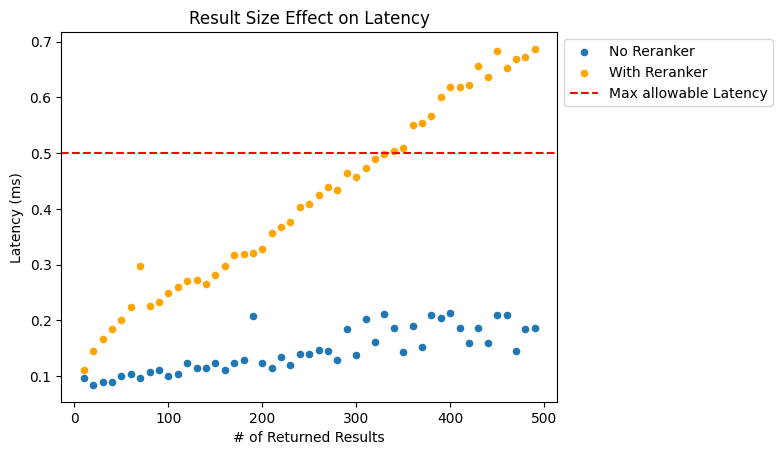

In [54]:
import time
import pandas as pd

def time_search(client: WeaviateWCS,
                collection_name: str,
                limit: int,
                rerank: bool
                ) -> float:
    '''
    Executes search given a limit value.
    Returns total time in seconds
    '''
    query = 'What is the best long term strategy for fat loss'
    start = time.perf_counter()
    response = client.hybrid_search(query, collection_name, limit=limit, return_properties=['content', 'title'])
    if rerank:
        reranked = reranker.rerank(response, query)
    end = time.perf_counter() - start
    return round(end, 3)

limit_values = list(range(10, 500, 10))

unranked_times = []
for n in tqdm(limit_values, 'Search: No Reranker'):
    unranked_times.append((time_search(client, collection_name, limit=n, rerank=False), n))


ranked_times = []
for n in tqdm(limit_values, 'Search: With Reranker'):
    ranked_times.append((time_search(client, collection_name, limit=n, rerank=True), n))



unranked = pd.DataFrame(unranked_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = unranked.plot.scatter(x='n', y='time', label='No Reranker', title='Result Size Effect on Latency')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')
hline = ax2.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label = "Max allowable Latency")
legend = ax2.legend(bbox_to_anchor = (1.0, 1))

# Assignment 2.2 - New Retrieval Benchmark
***
**Reevaluate your retrieval results, this time using hybrid search and a Reranker**

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.  Instantiate the `RetrievalEvaluationService` with an instance of your Weaviate retriever.  Then use the `execute_evaluation` method to run your retrieval benchmark.
- `execute_evaluation` is the same function from Notebook 3, albeit with some modifications to incorporate hybrid search and Reranker functionality.
- **Adjust the different hyperparameters to get the highest scoring retrieval score possible.**

In [56]:
!curl -o data/golden_datasets/golden_128.json https://raw.githubusercontent.com/americanthinker/rag-applications/main/data/golden_datasets/golden_128.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62370  100 62370    0     0   240k      0 --:--:-- --:--:-- --:--:--  240k


In [ ]:
from src.evaluation.retrieval_evaluation import RetrievalEvaluationService
from src.preprocessor.preprocessing import FileIO

eval_service = RetrievalEvaluationService(client)

In [70]:
from itertools import product

chunk_size = [128, 256, 512]

reranker = [
    "cross-encoder/ms-marco-MiniLM-L-6-v2",
    "BAAI/bge-small-en-v1.5",
    "abhinand/MedEmbed-small-v0.1",
    "avsolatorio/GIST-small-Embedding-v0",
    "all-MiniLM-L12-v2"
]

alpha = [0.2, 0.4, 0.6, 0.8]

retrieve_limit = [100, 200, 300]

top_k = [3, 5, 10]

set_properties = [
  ["content"],
  ["expanded_content"],
  ["content", "keywords"],
  ["content", "guest"],
  ["content", "title"],
  ["content", "guest", "keywords"],
  ["content", "guest", "keywords", "title"],
]

In [79]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_128.json"),
    collection_name="Huberman_minilm_12_128",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-6-v2"),
    alpha=0.2,
    retrieve_limit=100,
    top_k=3,
    chunk_size=128,
    query_properties=['content']
)

print(eval_results)

Queries: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
2024-12-16 05:02:13.277 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 1.36 minutes
2024-12-16 05:02:13.279 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=100,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-6-v2',
    chunk_size=128,
    chunk_overlap=0,
    total_misses=16,
    total_questions=100,
    alpha=0.2,
    search_type='all',
    kw_raw_hits=84,
    kw_mrr=0.79,
    vector_raw_hits=69,
    vector_mrr=0.65,
    hybrid_raw_hits=83,
    hybrid_mrr=0.77,
    kw_hit_rate=0.84,
    vector_hit_rate=0.69,
    hybrid_hit_rate=0.83,
    evaluation_time='1.36 minutes'
)

In [91]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_128.json"),
    collection_name="Huberman_minilm_12_128",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-6-v2"),
    alpha=0.40,
    retrieve_limit=150,
    top_k=3,
    chunk_size=128,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

Queries: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]
2024-12-16 06:02:31.511 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 1.7 minutes
2024-12-16 06:02:31.512 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-6-v2',
    chunk_size=128,
    chunk_overlap=0,
    total_misses=16,
    total_questions=100,
    alpha=0.4,
    search_type='all',
    kw_raw_hits=81,
    kw_mrr=0.78,
    vector_raw_hits=75,
    vector_mrr=0.69,
    hybrid_raw_hits=83,
    hybrid_mrr=0.79,
    kw_hit_rate=0.81,
    vector_hit_rate=0.75,
    hybrid_hit_rate=0.83,
    evaluation_time='1.7 minutes'
)

In [93]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_128.json"),
    collection_name="Huberman_minilm_12_128",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-12-v2"),
    alpha=0.55,
    retrieve_limit=150,
    top_k=3,
    chunk_size=128,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

Queries: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]
2024-12-16 06:15:54.875 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 2.69 minutes
2024-12-16 06:15:54.877 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-12-v2',
    chunk_size=128,
    chunk_overlap=0,
    total_misses=15,
    total_questions=100,
    alpha=0.55,
    search_type='all',
    kw_raw_hits=82,
    kw_mrr=0.79,
    vector_raw_hits=76,
    vector_mrr=0.72,
    hybrid_raw_hits=84,
    hybrid_mrr=0.8,
    kw_hit_rate=0.82,
    vector_hit_rate=0.76,
    hybrid_hit_rate=0.84,
    evaluation_time='2.69 minutes'
)

In [94]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_128.json"),
    collection_name="Huberman_minilm_12_128",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-12-v2"),
    alpha=0.10,
    retrieve_limit=150,
    top_k=3,
    chunk_size=128,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

Queries: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]
2024-12-16 06:18:36.370 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 2.69 minutes
2024-12-16 06:18:36.371 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-12-v2',
    chunk_size=128,
    chunk_overlap=0,
    total_misses=15,
    total_questions=100,
    alpha=0.1,
    search_type='all',
    kw_raw_hits=82,
    kw_mrr=0.79,
    vector_raw_hits=76,
    vector_mrr=0.72,
    hybrid_raw_hits=83,
    hybrid_mrr=0.8,
    kw_hit_rate=0.82,
    vector_hit_rate=0.76,
    hybrid_hit_rate=0.83,
    evaluation_time='2.69 minutes'
)

In [92]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_128.json"),
    collection_name="Huberman_minilm_12_128",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-12-v2"),
    alpha=0.25,
    retrieve_limit=150,
    top_k=3,
    chunk_size=128,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

Queries: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]
2024-12-16 06:07:04.025 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 2.67 minutes
2024-12-16 06:07:04.026 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-12-v2',
    chunk_size=128,
    chunk_overlap=0,
    total_misses=15,
    total_questions=100,
    alpha=0.25,
    search_type='all',
    kw_raw_hits=82,
    kw_mrr=0.79,
    vector_raw_hits=76,
    vector_mrr=0.72,
    hybrid_raw_hits=84,
    hybrid_mrr=0.8,
    kw_hit_rate=0.82,
    vector_hit_rate=0.76,
    hybrid_hit_rate=0.84,
    evaluation_time='2.67 minutes'
)

In [85]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_256.json"),
    collection_name="Huberman_minilm_12_256",
    reranker=ReRanker("cross-encoder/ms-marco-MiniLM-L-12-v2"),
    alpha=0.35,
    retrieve_limit=150,
    top_k=3,
    chunk_size=256,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Queries: 100%|██████████| 100/100 [04:34<00:00,  2.74s/it]
2024-12-16 05:51:50.175 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 4.57 minutes
2024-12-16 05:51:50.177 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-12-v2',
    chunk_size=256,
    chunk_overlap=0,
    total_misses=18,
    total_questions=100,
    alpha=0.35,
    search_type='all',
    kw_raw_hits=74,
    kw_mrr=0.63,
    vector_raw_hits=61,
    vector_mrr=0.53,
    hybrid_raw_hits=79,
    hybrid_mrr=0.67,
    kw_hit_rate=0.74,
    vector_hit_rate=0.61,
    hybrid_hit_rate=0.79,
    evaluation_time='4.57 minutes'
)

In [84]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_256.json"),
    collection_name="Huberman_minilm_12_256",
    reranker=ReRanker("ncbi/MedCPT-Cross-Encoder"),
    alpha=0.35,
    retrieve_limit=150,
    top_k=3,
    chunk_size=256,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Queries:   0%|          | 0/100 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Queries: 100%|██████████| 100/100 [12:58<00:00,  7.78s/it]
2024-12-16 05:47:13.707 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 12.97 minutes
2024-12-16 05:47:13.709 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='ncbi/MedCPT-Cross-Encoder',
    chunk_size=256,
    chunk_overlap=0,
    total_misses=21,
    total_questions=100,
    alpha=0.35,
    search_type='all',
    kw_raw_hits=68,
    kw_mrr=0.57,
    vector_raw_hits=58,
    vector_mrr=0.46,
    hybrid_raw_hits=74,
    hybrid_mrr=0.6,
    kw_hit_rate=0.68,
    vector_hit_rate=0.58,
    hybrid_hit_rate=0.74,
    evaluation_time='12.97 minutes'
)

In [83]:
eval_results = eval_service.execute_evaluation(
    dataset=FileIO.load_json("./data/golden_datasets/golden_256.json"),
    collection_name="Huberman_minilm_12_256",
    reranker=ReRanker("cross-encoder/mmarco-mMiniLMv2-L12-H384-v1"),
    alpha=0.35,
    retrieve_limit=150,
    top_k=3,
    chunk_size=256,
    query_properties=["content", "guest", "keywords", "title"],
)

print(eval_results)

Queries: 100%|██████████| 100/100 [04:42<00:00,  2.83s/it]
2024-12-16 05:34:01.702 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 4.71 minutes
2024-12-16 05:34:01.704 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=150,
    top_k=3,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/mmarco-mMiniLMv2-L12-H384-v1',
    chunk_size=256,
    chunk_overlap=0,
    total_misses=19,
    total_questions=100,
    alpha=0.35,
    search_type='all',
    kw_raw_hits=73,
    kw_mrr=0.67,
    vector_raw_hits=60,
    vector_mrr=0.54,
    hybrid_raw_hits=79,
    hybrid_mrr=0.7,
    kw_hit_rate=0.73,
    vector_hit_rate=0.6,
    hybrid_hit_rate=0.79,
    evaluation_time='4.71 minutes'
)

### Retrieval Score improvement

At this point in the course you have several options at your disposal to improve your retrieval score to maximize the relevance of the context that you will feed the LLM for the Question Answering phase of the system.  I'll list your options here, from least to most complex:
- Use hybrid search
- Experiment with the `alpha` parameter to see which value works best for this dataset
- Use a ReRanker
- Push the boundary on your reranker by maxing out the `retrieve_limit` value.  Try to keep latency below 500 ms.  
- Swap out your embedding model for a more performant one
- Find a better reranker on the MTEB leaderboard
- Fine-tune your embedding model
- Fine-tune your embedding model on a larger dataset than the 300 samples in the `training_data_300.json`.  You have the ability to create your own dataset through OpenAI and the `generate_finetune_datasets` notebook.
- Change the BM25 tokenizer

# Conclusion
***

Feel free to submit your new benchmark retrieval scores to move up on the Class Leaderboard!  I hope this notebook provided you with a better understanding of how Hybrid Search and CrossEncoders work under the hood.  
You are now prepared to move on to integrating your (high quality) retrieval results into an LLM for answer synthesis.  We'll next take a look at how we can build context options for the LLM and engineer our prompt to stack the deck in our favor.   Onward!